In [15]:
%matplotlib inline

In [1]:
import cv2
import os
import math
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten,MaxPooling2D,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
)
from tensorflow.keras.optimizers import Adam,SGD
from model_maker import make_model,evaluate_model

In [2]:
IMAGE_WIDTH=224
IMAGE_HEIGHT=224

(610, 224, 224, 1)


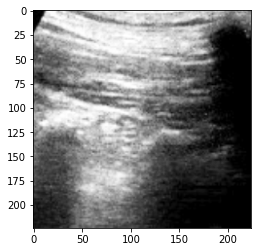

In [3]:
#Load all patients 
my_data = pd.read_csv('../data/Five_Frames_Per_patient.csv')
patients_data=pd.read_csv('../data/videos_data.csv')
data_array = my_data.to_numpy()
patients_array=patients_data["FileName"].to_numpy()
images_path = '../data/Five_Frames_Per_patient/'
no_of_test_patients=math.floor(patients_array.size*0.2) 
images_data = []
models = []

df=my_data
data_array=df.to_numpy()
for i in data_array:
    img = cv2.imread(images_path + i[0] + '.' + i[2], cv2.IMREAD_GRAYSCALE)
    img=  cv2.equalizeHist(img)
    img = cv2.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT))
    img_2d = img.reshape(IMAGE_WIDTH ,IMAGE_HEIGHT,1)
    images_data.append(img_2d)

X=np.asarray(images_data)
print(X.shape)
plt.imshow(X[0],cmap='gray')
y = np.asarray(my_data['Label'])

In [4]:
testPatient_indexes= [1,2,12,14,15,22,
                      33,34,37,42,43,52,53,
                      92,95,96,99,101,102,104,107,110,115,118]
#getting frame indexes of each patient
frames_index=[]
for i in testPatient_indexes:
  j=i*5
  z=j+5
  while j<z:
    frames_index.append(j)
    j+=1


In [5]:
y_fold=np.delete(y,frames_index,axis=0)
#Label encode classes to numbers
number = preprocessing.LabelEncoder()
y=number.fit_transform(y)
#One-hot Encode y
y=to_categorical(y,3)

In [6]:
# Adding the frames to X_test
X_test=np.take(X,frames_index,axis=0)
y_test=np.take(y,frames_index,axis=0)
# Removing the frames from X_train
X_train=np.delete(X,frames_index,axis=0)
y_train=np.delete(y,frames_index,axis=0)


# Scale the pixels
X_train=X_train/255.0
X_test=X_test/255.0

In [7]:
# initialize the training data augmentation object
MODEL_PATH=os.path.join('', "Conv2d-Better")

trainAug = ImageDataGenerator(
    rotation_range=10,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

mcp_save = ModelCheckpoint(
    MODEL_PATH,
    save_best_only=True,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

In [8]:
BATCH_SIZE=16
EPOCHS=20
LR=1e-4
opt = Adam(learning_rate=LR,decay=LR / 20)
# Define callbacks
earlyStopping = EarlyStopping(
    monitor='loss',
    patience=20,
    verbose=1,
    mode='min',
    restore_best_weights=True
)


reduce_lr_loss = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.7,
    patience=7,
    verbose=1,
    min_delta=1e-4,
    mode='min'
)

In [9]:
print('X_train: '+str(X_train.shape))
print('y_train: '+str(y_train.shape))
print('X_test: '+ str(X_test.shape))
print('y_test: '+ str(y_test.shape))

X_train: (490, 224, 224, 1)
y_train: (490, 3)
X_test: (120, 224, 224, 1)
y_test: (120, 3)


In [20]:
model=make_model()

In [21]:
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
history=model.fit(
    trainAug.flow(X_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    validation_data=(X_test, y_test),
    epochs=30,
    callbacks=[earlyStopping, mcp_save, reduce_lr_loss]
)

Epoch 1/30
30/30 [==============================] - 3s 76ms/step - loss: 1.2365 - accuracy: 0.4620 - val_loss: 1.0254 - val_accuracy: 0.4250

Epoch 00001: val_accuracy did not improve from 0.89167
Epoch 2/30
30/30 [==============================] - 2s 69ms/step - loss: 0.9080 - accuracy: 0.5401 - val_loss: 0.8591 - val_accuracy: 0.6000

Epoch 00002: val_accuracy did not improve from 0.89167
Epoch 3/30
30/30 [==============================] - 2s 68ms/step - loss: 0.7986 - accuracy: 0.6435 - val_loss: 0.7634 - val_accuracy: 0.7167

Epoch 00003: val_accuracy did not improve from 0.89167
Epoch 4/30
30/30 [==============================] - 2s 67ms/step - loss: 0.6938 - accuracy: 0.6878 - val_loss: 0.7042 - val_accuracy: 0.6750

Epoch 00004: val_accuracy did not improve from 0.89167
Epoch 5/30
30/30 [==============================] - 2s 71ms/step - loss: 0.6613 - accuracy: 0.7173 - val_loss: 0.6795 - val_accuracy: 0.7250

Epoch 00005: val_accuracy did not improve from 0.89167
Epoch 6/30
30/3

Train: 0.973, Test: 0.808


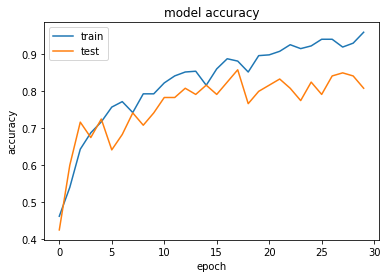

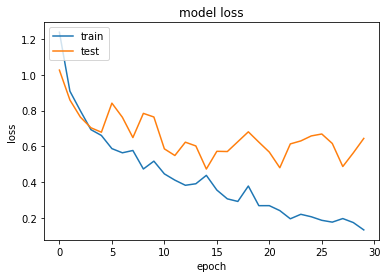

              precision    recall  f1-score   support

       Covid       1.00      0.67      0.80        30
   Pneumonia       0.82      0.80      0.81        35
     Healthy       0.76      0.91      0.83        55

    accuracy                           0.82       120
   macro avg       0.86      0.79      0.81       120
weighted avg       0.84      0.82      0.82       120

[[20  1  9]
 [ 0 28  7]
 [ 0  5 50]]


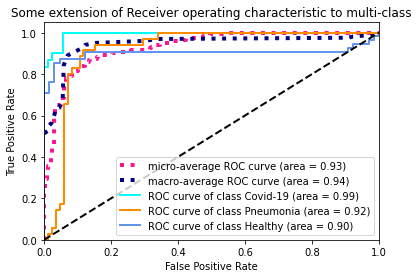

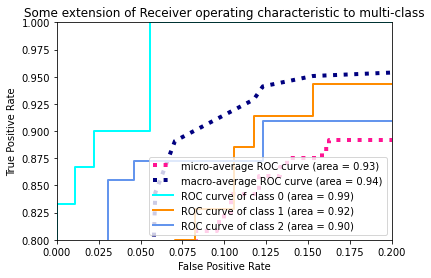

In [23]:
evaluate_model(model,history,X_train,y_train,X_test,y_test)

In [29]:
# MLP for Pima Indians Dataset with 10-fold cross validation
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold


# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=False)
cvscores = []
for train, test in kfold.split(X_train, y_fold):
  # create model
    model=make_model()
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    print('hi')
    model.fit(X_train[train], y_train[train], epochs=15, batch_size=10, verbose=0)
    # evaluate the model
    scores = model.evaluate(X_train[test], y_train[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

hi
accuracy: 51.02%
hi
accuracy: 61.22%
hi
accuracy: 73.47%
hi
accuracy: 84.69%
hi
accuracy: 71.43%
68.37% (+/- 11.44%)


In [26]:
y_pred=model.predict(X_test)
prediction = np.argmax(y_pred, axis=1)
real=np.argmax(y_test, axis=1)
from mostCommon import most_common,patient_score
patient_score(real,prediction)

[[ 4  0  2]
 [ 0  6  1]
 [ 0  1 10]]
              precision    recall  f1-score   support

           0      1.000     0.667     0.800         6
           1      0.857     0.857     0.857         7
           2      0.769     0.909     0.833        11

    accuracy                          0.833        24
   macro avg      0.875     0.811     0.830        24
weighted avg      0.853     0.833     0.832        24

